In [13]:
import pandas as pd
import os
import math
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix

def read_diamond(target_genome_blast_result):
    df = pd.read_csv(target_genome_blast_result, names = ['qseqid','evalue'], delimiter= '\t', header = None, index_col = None)

    # find best_evalue(smallest is the best)
    df.sort_values(by='evalue', axis='index', ascending=True, inplace=True)
    df.drop_duplicates(subset='qseqid', keep='first', inplace=True)
    return df

def best_e_value(df):
    """
    select best e-value for each gene WITHIN each target genome
    :param target_genome_blast_result:
    :return: best evalue of each gene within the target genome (series)
    """
    
    # find smallest e_value among gene that is not zero (for log transform later)
    smallest_e_value = df.loc[df['evalue'] != 0]['evalue'].min()  # the dataframe is sorted

    return smallest_e_value
def diamond_to_pivot(target_path, tid, gid):
    
    # initialize sparse matrix
    ma = lil_matrix((len(gid), len(tid)))
    # initialize normalization factor (second best evalue)
    sec_best_eval = 1
    
    target_files = os.listdir(target_path)
    for file in target_files:
        df = read_diamond(os.path.join(target_path, file))
        # change to gene id
        df['gid'] = df['qseqid'].map(gid)
        df.dropna(subset = ['gid'], inplace = True)
        df['gid'] = df['gid'].astype(int)
        
        # target id
        target_id = tid[file]
        
        log_eval = -np.log(df['evalue']) #np.inf means evalue is 0
        ma[df['gid'].tolist(), target_id] = log_eval.tolist() # store negative log to prevent underflow :)
        
        # best_evl
        local_best_eval = best_e_value(df)
        if local_best_eval < sec_best_eval:
            sec_best_eval = local_best_eval
        
    # normalize by sec best
    ma = ma/(-np.log(sec_best_eval))
        
    # replace inf with 1
    npm = ma.toarray()
    npm[np.where(npm == np.inf)] = 1
        
    ma = lil_matrix(npm)
        
    return ma, sec_best_eval
def discretize(ma, bins = 100):
    # convert to csr matrix and qcut
    csr = m.tocsr()
    q = pd.qcut(csr.data, q = bins, labels = False, duplicates = 'drop')
    
    # create a new csr matrix
    binned = csr_matrix((q, csr.indices, csr.indptr))
    
    return binned

    


In [14]:
import pickle
with open('../test_data/gene_id.pickle', 'rb') as f:
    gid = pickle.load(f)

with open('../test_data/genome_id.pickle', 'rb') as f:
    tid = pickle.load(f)
m, e = diamond_to_pivot('../test_data/diamond_results', tid, gid)
binned = discretize(m, bins = 10)

/home/hermuba/miniconda3/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
np.nansum(m.toarray())

0.0

1

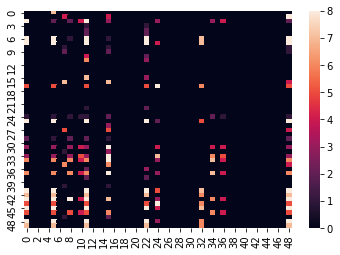

In [15]:
import seaborn as sns
sns.heatmap(binned.toarray())